# Questrade API Exploration Notebook

This notebook explores the Questrade API functionality provided in the `qt_api.py` module. We'll examine key functions for accessing account information, market data, and trade execution.

## Setup and Initialization

In [2]:
import sys
sys.path.append(r'C:\Users\Administrator\finstral-1')

In [3]:
import sys
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Import the Questrade API module
import src.qt_api.qt_api as qt

# Set some display options for better output
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)


## Authentication

First, we need to authenticate with the Questrade API. The module handles token management automatically.


In [4]:
# Get or refresh the authentication token
token_data = qt.get_questrade_token()
print("Authentication successful!")
print(f"API Server: {token_data['api_server']}")

Authentication successful!
API Server: https://api07.iq.questrade.com/


## Account Information

Let's explore the account information available through the API.

### Retrieve Account List

In [5]:
# Get all accounts
accounts = qt.get_questrade_accounts()
print(f"Found {len(accounts['accounts'])} accounts")

# Display account details in a DataFrame
account_df = pd.DataFrame(accounts['accounts'])
display(account_df)

# Store the primary account number for later use
if len(accounts['accounts']) > 0:
    primary_account = next((acc['number'] for acc in accounts['accounts'] if acc.get('isPrimary', False)), 
                          accounts['accounts'][0]['number'])
    print(f"Primary account: {primary_account}")

Found 4 accounts


,type,number,status,isPrimary,isBilling,clientAccountType
0,Margin,27955569,Active,True,True,Individual
1,TFSA,52541889,Active,False,False,Individual
2,RRSP,52814982,Active,False,False,Individual
3,FHSA,52963793,Active,False,False,Individual


Primary account: 27955569


### Retrieve Account Balances

In [6]:
# Get balances for the primary account
balances = qt.get_questrade_balances(primary_account)

# Display currency balances
currency_balances = pd.DataFrame(balances['perCurrencyBalances'])
print("Currency Balances:")
display(currency_balances)

# Display combined balances
combined_balances = pd.DataFrame(balances['combinedBalances'])
print("\nCombined Balances:")
display(combined_balances)

Currency Balances:


,currency,cash,marketValue,totalEquity,buyingPower,maintenanceExcess,isRealTime
0,CAD,1143.072000,0,1143.072000,3806.429760,1143.072000,True
1,USD,-801.869971,0,-801.869971,-2670.227003,-801.869971,True



Combined Balances:


,currency,cash,marketValue,totalEquity,buyingPower,maintenanceExcess,isRealTime
0,CAD,2.291686,0,2.291686,7.631314,2.291686,True
1,USD,1.610857,0,1.610857,5.364154,1.610857,True


### Retrieve Account Positions

Note: 'openPnL' field not available in the API response


,symbol,currentMarketValue,marketValue_pct,openQuantity,currentPrice,averageEntryPrice,totalCost
4,ZSP.TO,2289.2600,43.377893,29,78.9400,87.244828,2530.100012
3,ZCN.TO,1086.0500,20.578947,35,31.0300,32.049143,1121.720005
8,ZEA.TO,1059.3800,20.073593,47,22.5400,23.469363,1103.060061
1,XEC.TO,251.5500,4.766479,9,27.9500,29.252222,263.269998
10,BTCX.B.TO,245.7000,4.655630,14,17.5500,10.550000,147.700000
2,XGRO.TO,225.7600,4.277799,8,28.2200,29.692500,237.540000
7,WEED.TO,37.7000,0.714356,29,1.3000,72.904060,2114.217740
9,NEGG,25.2408,0.478274,104,0.2427,4.245460,441.527840
5,CNDU.TO,24.0300,0.455331,1,24.0300,18.230000,18.230000
6,ZEM.TO,20.5600,0.389580,1,20.5600,19.200000,19.200000


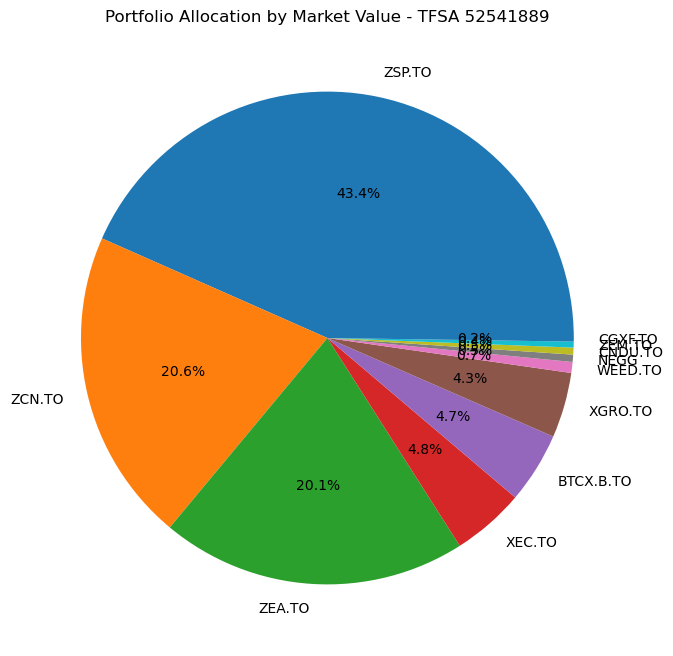

In [ ]:
# Get positions for the primary account
positions = qt.get_questrade_positions(account_df['number'][1])

# Get account type and number for the title
account_type = account_df['type'][1]
account_number = account_df['number'][1]

# Convert to DataFrame and display
if positions['positions']:
    positions_df = pd.DataFrame(positions['positions'])
    
    # Calculate market value percentage
    positions_df['marketValue_pct'] = positions_df['currentMarketValue'] / positions_df['currentMarketValue'].sum() * 100
    
    # Check if 'openPnL' exists in the dataframe before calculating profit/loss percentage
    if 'openPnL' in positions_df.columns:
        positions_df['profit_loss_pct'] = positions_df['openPnL'] / positions_df['totalCost'] * 100
        profit_cols = ['openPnL', 'profit_loss_pct']
    else:
        print("Note: 'openPnL' field not available in the API response")
        profit_cols = []
    
    # Sort by market value
    positions_df = positions_df.sort_values('currentMarketValue', ascending=False)
    
    # Display positions with important columns first
    cols = ['symbol', 'currentMarketValue', 'marketValue_pct', 'openQuantity', 
            'currentPrice', 'averageEntryPrice'] + profit_cols + ['totalCost']
    display(positions_df[cols])
    
    # Create a pie chart of position allocation
    plt.figure(figsize=(10, 8))
    plt.pie(positions_df['currentMarketValue'], labels=positions_df['symbol'], autopct='%1.1f%%')
    plt.title(f'Portfolio Allocation by Market Value - {account_type} {account_number}')
    plt.show()
else:
    print("No positions found in the account.")

### Retrieve Account Activities

,tradeDate,transactionDate,settlementDate,action,symbol,symbolId,description,currency,quantity,price,grossAmount,commission,netAmount,type
6,2025-04-02 00:00:00-04:00,2025-04-02 00:00:00-04:00,2025-04-02 00:00:00-04:00,,ZCN.TO,2701877,BMO S&P/TSX CAPPED COMPOSITE INDEX ETF CAD UNI...,CAD,0,0.23,0.00,0,8.05,Dividends
8,2025-04-02 00:00:00-04:00,2025-04-02 00:00:00-04:00,2025-04-02 00:00:00-04:00,,ZEA.TO,5587643,BMO MSCI EAFE INDEX ETF CAD UNITS DIST ON...,CAD,0,0.16,0.00,0,7.36,Dividends
11,2025-04-02 00:00:00-04:00,2025-04-02 00:00:00-04:00,2025-04-02 00:00:00-04:00,,ZSP.TO,2965569,BMO S&P 500 INDEX ETF CAD UNITS DIST ON ...,CAD,0,0.21,0.00,0,5.88,Dividends
2,2025-03-31 00:00:00-04:00,2025-04-01 00:00:00-04:00,2025-04-01 00:00:00-04:00,Buy,ZEA.TO,5587643,BMO MSCI EAFE INDEX ETF CAD UNITS WE ACTED A...,CAD,1,24.54,-24.54,0,-24.54,Trades
4,2025-03-31 00:00:00-04:00,2025-04-01 00:00:00-04:00,2025-04-01 00:00:00-04:00,Buy,ZSP.TO,2965569,BMO S&P 500 INDEX ETF CAD UNITS WE ACTED AS ...,CAD,1,86.87,-86.87,0,-86.87,Trades
5,2025-03-31 00:00:00-04:00,2025-03-31 00:00:00-04:00,2025-03-31 00:00:00-04:00,,CGXF.TO,26941696,CI GOLD+ GIANTSCOVERED CALL ETF HEDGED COMMON ...,CAD,0,0.23,0.00,0,0.23,Dividends
10,2025-03-31 00:00:00-04:00,2025-03-31 00:00:00-04:00,2025-03-31 00:00:00-04:00,,XGRO.TO,1897749,ISHARES CORE GROWTH ETF PORTFOLIO INDEX COM UN...,CAD,0,0.11,0.00,0,0.89,Dividends
7,2025-03-28 00:00:00-04:00,2025-03-28 00:00:00-04:00,2025-03-28 00:00:00-04:00,CON,,0,PAD CONT 5254188914,CAD,0,0.00,0.00,0,100.00,Deposits
0,2025-03-17 00:00:00-04:00,2025-03-18 00:00:00-04:00,2025-03-18 00:00:00-04:00,Buy,ZSP.TO,2965569,BMO S&P 500 INDEX ETF SERIES ETF UNITS WE AC...,CAD,1,89.07,-89.07,0,-89.07,Trades
9,2025-03-14 00:00:00-04:00,2025-03-14 00:00:00-04:00,2025-03-14 00:00:00-04:00,CON,,0,PAD CONT 5254188914,CAD,0,0.00,0.00,0,100.00,Deposits



Activity Types Summary:


type
Dividends    5
Trades       5
Deposits     2
Name: count, dtype: int64

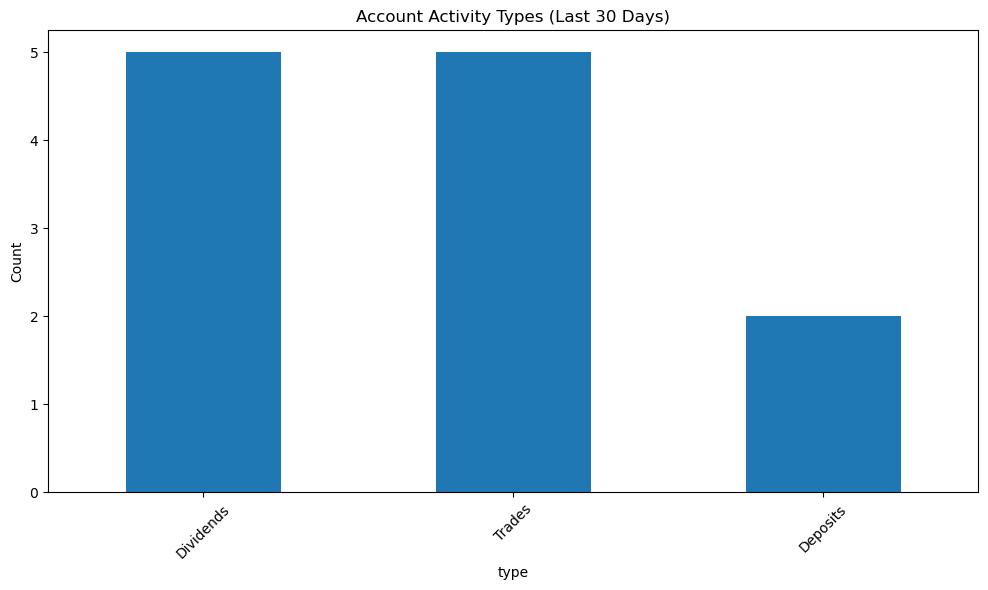

In [16]:
# Get account activities for the last 30 days


days_back = 30
start_time = (datetime.datetime.now() - datetime.timedelta(days=days_back)).replace(
    hour=0, minute=0, second=0, microsecond=0).astimezone().isoformat()
end_time = datetime.datetime.now().astimezone().isoformat()

activities = qt.get_account_activities(account_df['number'][1], start_time, end_time)

if activities['activities']:
    # Convert to DataFrame
    activities_df = pd.DataFrame(activities['activities'])
    
    # Convert date columns to datetime
    date_cols = [col for col in activities_df.columns if 'Date' in col]
    for col in date_cols:
        activities_df[col] = pd.to_datetime(activities_df[col])
    
    # Sort by transaction date
    activities_df = activities_df.sort_values('transactionDate', ascending=False)
    
    # Display activities
    display(activities_df.head(10))
    
    # Summary of activity types
    activity_types = activities_df['type'].value_counts()
    print("\nActivity Types Summary:")
    display(activity_types)
    
    # Plot activity types
    plt.figure(figsize=(12, 6))
    activity_types.plot(kind='bar')
    plt.title('Account Activity Types (Last 30 Days)')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("No activities found for the selected time period.")


### Retrieve Order History

,symbol,side,totalQuantity,filledQuantity,limitPrice,state,orderType,creationTime
4,ZSP.TO,Buy,1,1,86.88,Executed,Limit,2025-03-31 10:32:46.168000-04:00
3,ZEA.TO,Buy,1,1,24.56,Executed,Limit,2025-03-31 10:32:45.729000-04:00
2,ZSP.TO,Buy,1,1,89.08,Executed,Limit,2025-03-17 15:13:42.228000-04:00
1,ZCN.TO,Buy,2,2,32.82,Executed,Limit,2025-03-10 10:47:43.500000-04:00
0,BTCX.B.TO,Buy,2,2,16.84,Executed,Limit,2025-03-10 10:47:42.934000-04:00



Order State Summary:


state
Executed    5
Name: count, dtype: int64

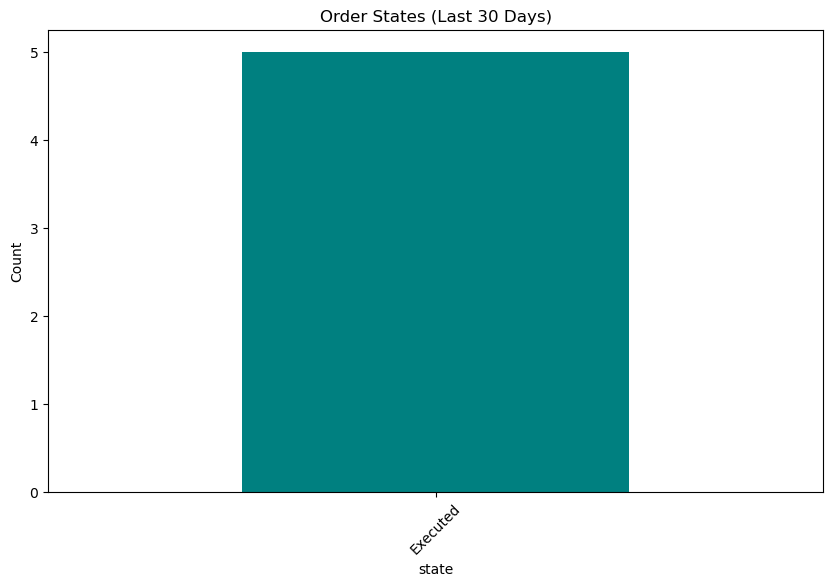

In [ ]:
# Get order history for the last 30 days
orders = qt.get_account_orders(account_df['number'][1], start_time, end_time)

if orders['orders']:
    # Convert to DataFrame
    orders_df = pd.DataFrame(orders['orders'])
    
    # Convert date columns to datetime
    time_cols = [col for col in orders_df.columns if 'Time' in col]
    for col in time_cols:
        orders_df[col] = pd.to_datetime(orders_df[col])
    
    # Sort by creation time
    orders_df = orders_df.sort_values('creationTime', ascending=False)
    
    # Display orders with selected columns
    cols = ['symbol', 'side', 'totalQuantity', 'filledQuantity', 'limitPrice', 
            'state', 'orderType', 'creationTime']
    display(orders_df[cols].head(10))
    
    # Order state summary
    order_states = orders_df['state'].value_counts()
    print("\nOrder State Summary:")
    display(order_states)
    
    # Plot order states
    plt.figure(figsize=(10, 6))
    order_states.plot(kind='bar', color='teal')
    plt.title('Order States (Last 30 Days)')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("No orders found for the selected time period.")


## Market Data

Now let's explore market data functions.

### Symbol Search

In [5]:
# Search for symbols
search_term = "AAPL"  # Try different search terms like "TSLA", "MSFT", etc.
search_results = qt.search_symbols(search_term)

if search_results['symbols']:
    search_df = pd.DataFrame(search_results['symbols'])
    display(search_df)
    
    # Store a symbol ID for later use
    sample_symbol_id = search_df.iloc[0]['symbolId']
    sample_symbol = search_df.iloc[0]['symbol']
    print(f"Selected symbol for further analysis: {sample_symbol} (ID: {sample_symbol_id})")
else:
    print(f"No results found for '{search_term}'")


,symbol,symbolId,description,securityType,listingExchange,isTradable,isQuotable,currency
0,AAPL,8049,APPLE INC,Stock,NASDAQ,True,True,USD
1,AAPL.TO,39472334,APPLE INC,Stock,TSX,True,True,CAD
2,AVSPY.IN,28301,AAPL Alpha Index,Index,NASDAQI,False,True,USD
3,AAPW,59883807,ROUNDHILL AAPL WEEKLYPAY ETF,Stock,BATS,True,True,USD
4,AAPL.TO,37727146,APPLE INC CDR (CAD HEDGED) DEPOSITARY RECEIPTS...,Stock,NEO,False,False,CAD
5,NY2LAAPL.IN,19786673,ICE Leveraged 2x AAPL Index,Index,NYSEGIF,False,True,USD
6,APLY,47195488,TIDAL TRUST II YIELDMAX AAPL OPTION INCOME STR...,Stock,ARCA,True,True,USD
7,AAPB,43621933,GRANITESHARES ETF TRUST 2X LONG AAPL DAILY ETF,Stock,NASDAQ,True,True,USD
8,AAPD,43621934,DIREXION SHARES ETF TRUST DAILY AAPL BEAR 1X SHS,Stock,NASDAQ,True,True,USD
9,AAPU,43621935,DIREXION SHARES ETF TRUST DAILY AAPL BULL 2X S...,Stock,NASDAQ,True,True,USD


Selected symbol for further analysis: AAPL (ID: 8049)


### Symbol Details

In [6]:
# Get detailed information about the selected symbol
symbol_details = qt.get_symbol_details(symbol_id=sample_symbol_id)

if symbol_details['symbols']:
    # Display as a transposed DataFrame for better readability
    details_df = pd.DataFrame(symbol_details['symbols']).iloc[0]
    display(pd.DataFrame(details_df).rename(columns={0: 'Value'}))
else:
    print(f"No details found for symbol ID {sample_symbol_id}")

,Value
symbol,AAPL
symbolId,8049
prevDayClosePrice,188.38
highPrice52,260.1
lowPrice52,164.075
averageVol3Months,54526494
averageVol20Days,58865047
outstandingShares,15022070000
eps,6.3
pe,32.25238


### Market Quotes

In [8]:
# Get real-time quote for the selected symbol
quote = qt.get_market_quote(symbol_id=sample_symbol_id)

if quote['quotes']:
    quote_data = quote['quotes'][0]
    
    # Create a more readable display of the quote information
    quote_df = pd.Series(quote_data)
    display(pd.DataFrame(quote_df).rename(columns={0: 'Value'}))
    
    # Show bid-ask spread
    if 'bidPrice' in quote_data and 'askPrice' in quote_data and quote_data['bidPrice'] is not None and quote_data['askPrice'] is not None:
        spread = quote_data['askPrice'] - quote_data['bidPrice']
        spread_pct = (spread / quote_data['askPrice']) * 100
        print(f"Bid-Ask Spread: ${spread:.2f} ({spread_pct:.2f}%)")
    else:
        print("Bid-Ask Spread: Not available (bid or ask prices are None)")
else:
    print(f"No quote data found for symbol ID {sample_symbol_id}")

,Value
symbol,AAPL
symbolId,8049
tier,
bidPrice,None
bidSize,0
askPrice,None
askSize,0
lastTradePriceTrHrs,188.38
lastTradePrice,188.38
lastTradeSize,0


Bid-Ask Spread: Not available (bid or ask prices are None)


### Historical Candles


,end,low,high,open,close,volume,VWAP
start,,,,,,,
2025-03-07 09:00:00+00:00,2025-03-07 10:00:00+00:00,234.45,234.5800,234.55,234.56,3404,234.479601
2025-03-07 10:00:00+00:00,2025-03-07 11:00:00+00:00,234.45,234.7900,234.56,234.79,3081,234.544232
2025-03-07 11:00:00+00:00,2025-03-07 12:00:00+00:00,234.60,234.7700,234.60,234.70,7145,234.599690
2025-03-07 12:00:00+00:00,2025-03-07 13:00:00+00:00,234.37,234.9200,234.69,234.55,9396,234.597501
2025-03-07 13:00:00+00:00,2025-03-07 14:00:00+00:00,234.22,236.0997,234.68,234.40,67676,234.899203


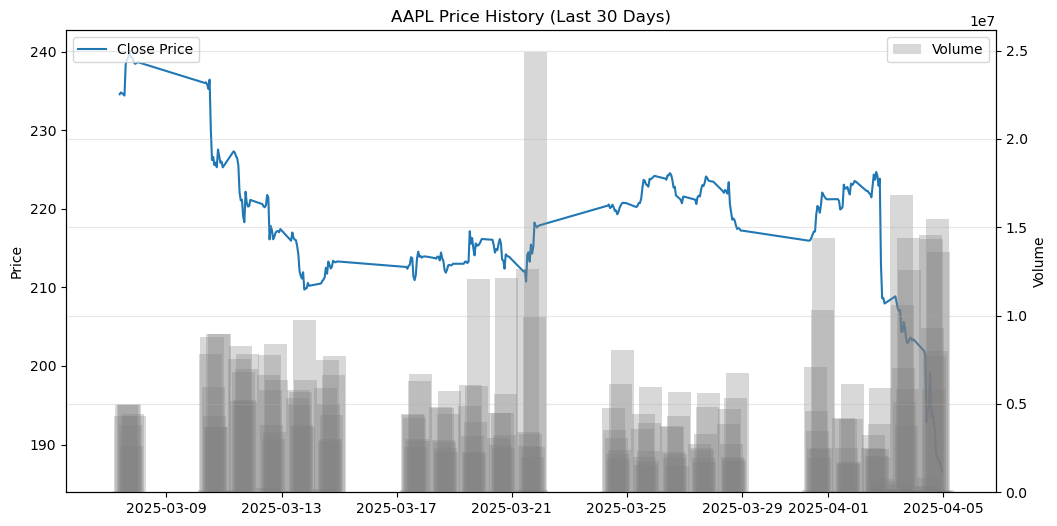

,Value
Mean Daily Return,-0.07%
Std Dev of Daily Returns,0.63%
Max Daily Gain,2.29%
Max Daily Loss,-4.93%
Total Return (Period),-20.45%


In [16]:
# Get historical candle data for the selected symbol
# For the last 30 days with daily candles
days_back = 30
start_time = (datetime.datetime.now() - datetime.timedelta(days=days_back)).replace(
    hour=0, minute=0, second=0, microsecond=0).astimezone().isoformat()
end_time = datetime.datetime.now().astimezone().isoformat()

candles = qt.get_candles(sample_symbol_id, start_time, end_time, interval="OneHour")

if candles['candles']:
    candles_df = pd.DataFrame(candles['candles'])
    
    # Convert start/end to datetime with utc=True to avoid FutureWarning
    candles_df['start'] = pd.to_datetime(candles_df['start'], utc=True)
    candles_df['end'] = pd.to_datetime(candles_df['end'], utc=True)
    
    # Set start as index
    candles_df.set_index('start', inplace=True)
    
    display(candles_df.head())
    
    # Plot the candlestick data
    plt.figure(figsize=(12, 6))
    
    # Plot OHLC
    plt.plot(candles_df.index, candles_df['close'], label='Close Price')
    
    # Add volume as a bar chart on a secondary axis
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    ax2.bar(candles_df.index, candles_df['volume'], alpha=0.3, color='gray', label='Volume')
    
    plt.title(f'{sample_symbol} Price History (Last {days_back} Days)')
    ax1.set_ylabel('Price')
    ax2.set_ylabel('Volume')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Calculate and display some basic statistics
    returns = candles_df['close'].pct_change().dropna()
    stats = {
        'Mean Daily Return': returns.mean() * 100,
        'Std Dev of Daily Returns': returns.std() * 100,
        'Max Daily Gain': returns.max() * 100,
        'Max Daily Loss': returns.min() * 100,
        'Total Return (Period)': ((candles_df['close'].iloc[-1] / candles_df['close'].iloc[0]) - 1) * 100
    }
    
    stats_df = pd.Series(stats, name='Value')
    stats_df = pd.DataFrame(stats_df)
    stats_df['Value'] = stats_df['Value'].map('{:.2f}%'.format)
    display(stats_df)
else:
    print(f"No candle data found for symbol ID {sample_symbol_id}")


## Market Information


In [18]:
# Get information about available markets
markets = qt.get_markets()

if markets['markets']:
    markets_df = pd.DataFrame(markets['markets'])
    
    # Print available columns to debug
    print("Available columns:", markets_df.columns.tolist())
    
    # Display main market information - select only columns that exist
    columns_to_display = ['name', 'extendedStartTime', 'startTime', 'endTime', 'extendedEndTime']
    # Add currency if it exists
    if 'currency' in markets_df.columns:
        columns_to_display.append('currency')
    
    simple_markets_df = markets_df[columns_to_display]
    display(simple_markets_df)
    
    # Show market hours visually
    market_hours = []
    for _, market in simple_markets_df.iterrows():
        # Extract hours for visualization
        ext_start = pd.to_datetime(market['extendedStartTime']).strftime('%H:%M')
        reg_start = pd.to_datetime(market['startTime']).strftime('%H:%M')
        reg_end = pd.to_datetime(market['endTime']).strftime('%H:%M')
        ext_end = pd.to_datetime(market['extendedEndTime']).strftime('%H:%M')
        
        market_data = {
            'Market': market['name'],
            'Pre-Market': f"{ext_start} - {reg_start}",
            'Regular Hours': f"{reg_start} - {reg_end}",
            'After Hours': f"{reg_end} - {ext_end}"
        }
        
        # Add currency if it exists
        if 'currency' in market:
            market_data['Currency'] = market['currency']
        
        market_hours.append(market_data)
    
    hours_df = pd.DataFrame(market_hours)
    display(hours_df)
else:
    print("No market information available")


Available columns: ['name', 'tradingVenues', 'defaultTradingVenue', 'primaryOrderRoutes', 'secondaryOrderRoutes', 'level1Feeds', 'level2Feeds', 'extendedStartTime', 'startTime', 'endTime', 'extendedEndTime', 'snapQuotesLimit']


,name,extendedStartTime,startTime,endTime,extendedEndTime
0,TSX,2025-04-06T07:00:00.000000-04:00,2025-04-06T09:30:00.000000-04:00,2025-04-06T16:00:00.000000-04:00,2025-04-06T20:00:00.000000-04:00
1,TSXV,2025-04-06T07:00:00.000000-04:00,2025-04-06T09:30:00.000000-04:00,2025-04-06T16:00:00.000000-04:00,2025-04-06T20:00:00.000000-04:00
2,MX,2025-04-06T07:00:00.000000-04:00,2025-04-06T09:30:00.000000-04:00,2025-04-06T16:00:00.000000-04:00,2025-04-06T20:00:00.000000-04:00
3,CNSX,2025-04-06T07:00:00.000000-04:00,2025-04-06T09:30:00.000000-04:00,2025-04-06T16:00:00.000000-04:00,2025-04-06T20:00:00.000000-04:00
4,NASDAQ,2025-04-06T04:00:00.000000-04:00,2025-04-06T09:30:00.000000-04:00,2025-04-06T16:00:00.000000-04:00,2025-04-06T20:00:00.000000-04:00
5,NYSE,2025-04-06T04:00:00.000000-04:00,2025-04-06T09:30:00.000000-04:00,2025-04-06T16:00:00.000000-04:00,2025-04-06T20:00:00.000000-04:00
6,NYSEAM,2025-04-06T04:00:00.000000-04:00,2025-04-06T09:30:00.000000-04:00,2025-04-06T16:00:00.000000-04:00,2025-04-06T20:00:00.000000-04:00
7,ARCA,2025-04-06T04:00:00.000000-04:00,2025-04-06T09:30:00.000000-04:00,2025-04-06T16:00:00.000000-04:00,2025-04-06T20:00:00.000000-04:00
8,BATS,2025-04-06T04:00:00.000000-04:00,2025-04-06T09:30:00.000000-04:00,2025-04-06T16:00:00.000000-04:00,2025-04-06T20:00:00.000000-04:00
9,OPRA,2025-04-06T07:00:00.000000-04:00,2025-04-06T09:30:00.000000-04:00,2025-04-06T16:00:00.000000-04:00,2025-04-06T20:00:00.000000-04:00


,Market,Pre-Market,Regular Hours,After Hours
0,TSX,07:00 - 09:30,09:30 - 16:00,16:00 - 20:00
1,TSXV,07:00 - 09:30,09:30 - 16:00,16:00 - 20:00
2,MX,07:00 - 09:30,09:30 - 16:00,16:00 - 20:00
3,CNSX,07:00 - 09:30,09:30 - 16:00,16:00 - 20:00
4,NASDAQ,04:00 - 09:30,09:30 - 16:00,16:00 - 20:00
5,NYSE,04:00 - 09:30,09:30 - 16:00,16:00 - 20:00
6,NYSEAM,04:00 - 09:30,09:30 - 16:00,16:00 - 20:00
7,ARCA,04:00 - 09:30,09:30 - 16:00,16:00 - 20:00
8,BATS,04:00 - 09:30,09:30 - 16:00,16:00 - 20:00
9,OPRA,07:00 - 09:30,09:30 - 16:00,16:00 - 20:00


## Conclusion

This notebook has demonstrated the key functionality of the Questrade API, including:

1. Authentication and token management
2. Account information retrieval (balances, positions, activities)
3. Market data access (symbol search, quotes, historical data)
4. Trade history and order information

The API provides comprehensive access to Questrade's trading platform, allowing for portfolio analysis, market research, and potentially automated trading strategies.